In [1]:
import stackstac
import pystac_client
import pyproj
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo
import numpy as np
import matplotlib.pyplot as plt

catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

# search = catalog.search(
#     collections=['landsat-c2-l2'],  
#     intersects=dict(type="Point", coordinates=[20, 5]),
#     datetime="2008-02-01/2008-06-01",
#     # query={"eo:cloud_cover": {"lt": 20}},  
#     query={
#         "platform": {"in": ["landsat-5", "landsat-8"]},
#           # "eo:cloud_cover": {"lt": 20}
#           },  
#     limit=1,
# )
# items = pc.sign(search); items[0].properties

In [2]:
aoi = dict(type="Point", coordinates=[20, 5])
daterange="2008-02-01/2010-06-01"
cloud_cover=20
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "landsat-c2-l2"]},
    {"op": "in", "args": [{"property": "platform"}, [
        # "landsat-5", 
        "landsat-7", 
        # "landsat-8"
    ]]},
    {"op": "lt", "args": [{"property": "eo:cloud_cover"}, cloud_cover]},
      
  ]
})
# first_item = next(search.get_items())
# items = pc.sign_item(first_item).assets
items = pc.sign(search); print(len(items)); items[0].properties

14


{'gsd': 30,
 'created': '2022-05-06T16:39:44.838226Z',
 'sci:doi': '10.5066/P9C7I13B',
 'datetime': '2010-03-08T08:47:50.649736Z',
 'platform': 'landsat-7',
 'proj:epsg': 32634,
 'proj:shape': [6961, 7981],
 'description': 'Landsat Collection 2 Level-2',
 'instruments': ['etm+'],
 'eo:cloud_cover': 7.0,
 'proj:transform': [30.0, 0.0, 236385.0, 0.0, -30.0, 584415.0],
 'view:off_nadir': 0,
 'landsat:wrs_row': '057',
 'landsat:scene_id': 'LE71800572010067ASN00',
 'landsat:wrs_path': '180',
 'landsat:wrs_type': '2',
 'view:sun_azimuth': 106.1904478,
 'landsat:correction': 'L2SP',
 'view:sun_elevation': 57.65138268,
 'landsat:cloud_cover_land': 7.0,
 'landsat:collection_number': '02',
 'landsat:collection_category': 'T1'}

In [8]:
stack = stackstac.stack(
    items, assets=["red", "green", "blue",]).where(lambda x: x > 0, other=np.nan)
x_utm, y_utm = pyproj.Proj(stack.crs)(20, 5)
buffer = 1000  # meters
data = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
data = ((data - data.min()) ) / (data.max() - data.min())
image = data.median("time", keep_attrs=True).compute()

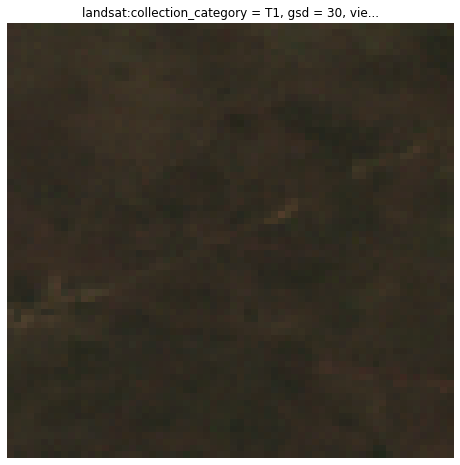

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);